In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import csv
import unidecode
import os
import numpy as np
import zlib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
from source import hyper_tunning
import seaborn as sns
from source import heatmap
from source import scatterplots
from source import feature_sel
import dateutil
import datetime
from ipywidgets import widgets, interactive_output
from IPython.display import display
import random
import itertools
import warnings
from sklearn.preprocessing import QuantileTransformer
import pickle

warnings.filterwarnings("ignore")


# Lectura de Tablas

In [15]:
# Lista con los nombres de los archivos csv de la tablas
names = [os.path.splitext(i)[0] for i in os.listdir("data") if os.path.splitext(i)[0].startswith("df")]

# Lectura de las tablas
for i in names:
  # Lectura de cronicos
  if i.endswith("cronicos"):
    # Crear DataFrame
    df = pd.read_csv(f'data/{i}.csv', delimiter=";", encoding="latin-1", low_memory=False)

    # Cambiar caracteres especiales de las columnas
    with open(f'data/{i}.csv', "r", encoding="utf-8") as f:
      # Leer primera fila (nombre de columnas)
      text = csv.reader(f)
      # Crear variable
      columns = next(text)

    # Remover caracteres especiales
    columns = unidecode.unidecode(columns[0]).split(";")
    # Cambiar nombre de columnas en el DataFrame
    df.columns = columns
    # Reemplazar valores sin informacion por valores nulos
    df.replace(["", "([sS]in\s)", "ND"], [np.nan]*3, regex=True, inplace=True)
    # Crear variables locales de los diferentes DataFrames
    locals().update({i:df})

  # Lectura usuarios y egresos
  else:
    # Crear DataFrame
    df = pd.read_csv(f'data/{i}.csv', delimiter=",", encoding="latin-1", low_memory=False)

    # Cambiar caracteres especiales de las columnas
    with open(f'data/{i}.csv', "r", encoding="utf-8") as f:
      # Leer primera fila (nombre de columnas)
      text = csv.reader(f)
      # Crear variable
      columns = next(text)
      # rows = np.array([unidecode.unidecode(";".join(i)).split(";") for i in text])

    # Remover caracteres especiales
    columns = unidecode.unidecode(";".join(columns)).split(";")
    # dic = {j:rows[:,i] for i,j in enumerate(columns)}
    # df = pd.DataFrame(dic)
    # Cambiar nombre de columnas en el DataFrame
    df.columns = columns
    # Reemplazar valores sin informacion por valores nulos
    df.replace(["", "([sS]in\s)", "ND"], [np.nan]*3, regex=True, inplace=True)
    # Crear variables locales de los diferentes DataFrames
    locals().update({i:df})



# Valores nulos antes de exploracion y procesamiento

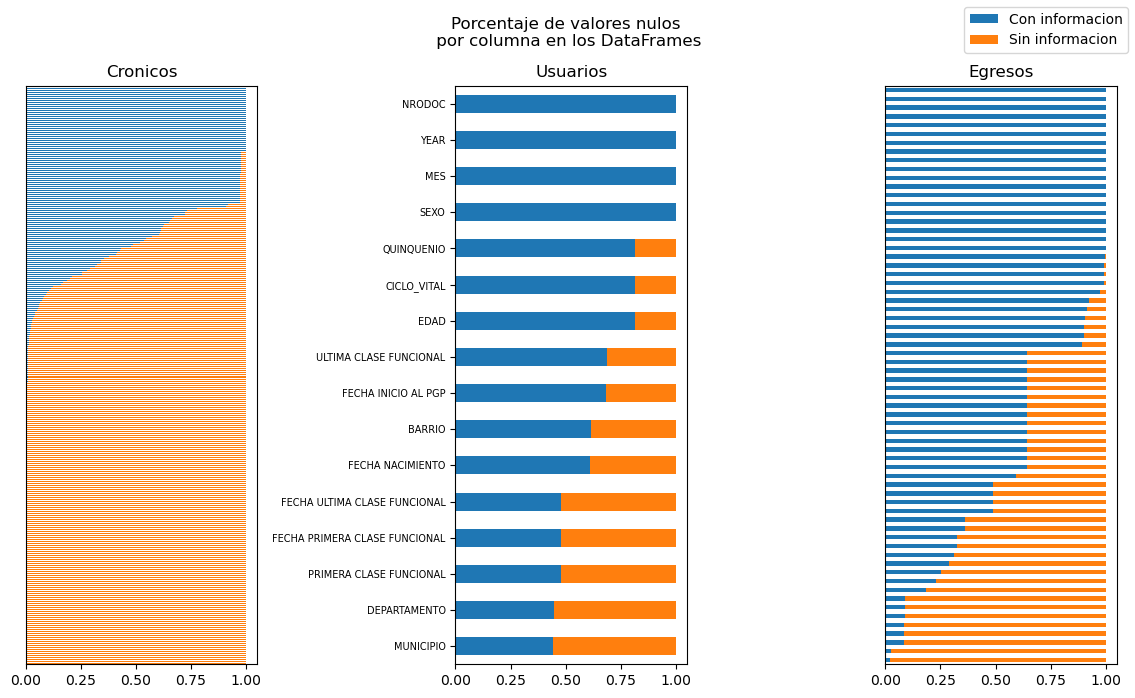

In [3]:
# Crear figura
fig, axes = plt.subplots(1, 3, figsize=(7*((1+np.sqrt(5))/2), 7))

# Iterar por cada base de datos
for i, j, k in zip(range(3), [df_cronicos, df_usuarios, df_egresos], ["Cronicos", "Usuarios", "Egresos"]):

  df_na = j.isna().apply(pd.Series.value_counts, normalize=True).T.fillna(0)

  df_na.sort_values(by=True, ascending=False).plot(kind="barh", stacked=True, legend=False, ax=axes[i], title=k)
  if i == 1:
    axes[i].set_yticklabels(df_na.sort_values(by=True, ascending=False).index ,fontsize=7)
  else:
    axes[i].set_yticks([])

fig.suptitle("Porcentaje de valores nulos\n por columna en los DataFrames")
fig.legend(axes[0].patch, labels=["Con informacion", "Sin informacion"])
plt.tight_layout()
plt.show()

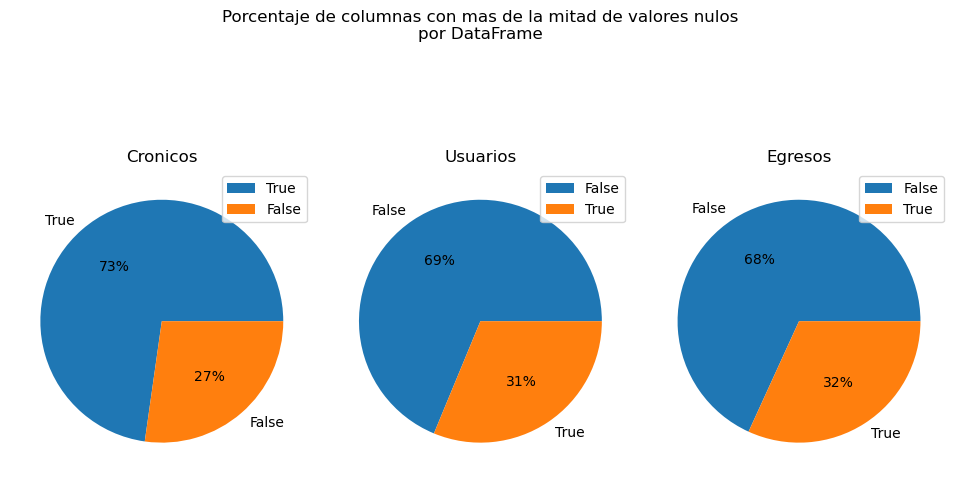

In [4]:
# Crear figura
fig, axes = plt.subplots(1, 3, figsize=(6*((1+np.sqrt(5))/2), 6))

# Iterar por cada base de datos
for i, j, k in zip(range(3), [df_cronicos, df_usuarios, df_egresos], ["Cronicos", "Usuarios", "Egresos"]):

  df_na = (j.isna().sum() > int(j.shape[0]/2)).value_counts()
  axes[i].pie(df_na.values, autopct="%1.0f%%", labels=[df_na.sort_values(ascending=False).index[0], df_na.sort_values(ascending=False).index[1]])
  axes[i].set_title(k)
  axes[i].legend()


fig.suptitle("Porcentaje de columnas con mas de la mitad de valores nulos\npor DataFrame")
# fig.legend(axes[0].patch, labels=["Con informacion", "Sin informacion"])
fig.tight_layout()
fig.show()

In [5]:
wid_1 = widgets.Dropdown(options=df_cronicos.loc[:,"NRODOC"].unique().tolist())

def groupby(user):

  df = df_cronicos.groupby("NRODOC").get_group(user)
  display(df)

output = interactive_output(groupby, {"user":wid_1})

display(wid_1, output)


Dropdown(options=(311144, 308418, 308573, 307549, 307044, 309419, 308437, 308637, 308561, 308563, 310132, 3095…

Output()

# Usuarios

In [ ]:
# Columnas con el mismo valor para todos los usuarios
cols = ["FECHA NACIMIENTO", "BARRIO", "MUNICIPIO", "DEPARTAMENTO", "FECHA INICIO AL PGP", "FECHA PRIMERA CLASE FUNCIONAL", "PRIMERA CLASE FUNCIONAL"]

# Filtro de usuarios mayores de 60 años y con valores NA
mask = (df_usuarios["EDAD"] >= 60) | (df_usuarios["EDAD"].isna())

# Filtrar base de datos
df_usuarios = df_usuarios[mask]

# Convertir fechas a formato date time
df_usuarios["FECHA NACIMIENTO"] = pd.to_datetime(df_usuarios["FECHA NACIMIENTO"], format="mixed")

# Diccionario con numeros de meses
spanish_months = {"ENERO": 1, "FEBRERO": 2, "MARZO": 3, "ABRIL": 4,
                  "MAYO": 5, "JUNIO": 6, "JULIO": 7, "AGOSTO": 8,
                  "SEPTIEMBRE": 9, "OCTUBRE": 10, "NOVIEMBRE": 11, "DICIEMBRE": 12}

# Cambio de nombre a numero de mes
df_usuarios["MES"] = df_usuarios["MES"].replace(spanish_months)

# Creacion de columna datetime con la fecha de diligenciamiento del formulario
df_usuarios["DATE"] = pd.to_datetime((df_usuarios["YEAR"].astype(str) + "/" + df_usuarios["MES"].astype(str)), format="%Y/%m")

# Llenar valores nulos de las columnas repetidas para cada paciente
for i in df_usuarios["NRODOC"].unique():

    df_usuarios.loc[df_usuarios.groupby("NRODOC").get_group(i).index, cols] = df_usuarios.groupby("NRODOC").get_group(i)[cols].bfill().ffill()

# Indexes con valores nulos para la fecha de nacimiento
fnna_index = df_usuarios[df_usuarios["FECHA NACIMIENTO"].isna()].index

# Reemplazar los valores de la fecha de nacimiento de los index previos
for id in df_usuarios.loc[fnna_index, "NRODOC"].unique().tolist():

  df = df_usuarios.copy().groupby("NRODOC").get_group(id)

  edad = df["EDAD"].min()
  fecha = df["DATE"].min()
  try:

    birth = fecha - datetime.timedelta(days=edad*365.25)
    df_usuarios.loc[df_usuarios["NRODOC"] == id, "FECHA NACIMIENTO"] = df.groupby("NRODOC").get_group(id)["FECHA NACIMIENTO"].fillna(birth)

  except ValueError:
    pass

# Eliminar filas con Edad y Fecha de nacimiento nulas (no se tiene informacion del paciente)
df_usuarios.dropna(subset=["EDAD", "FECHA NACIMIENTO"], how="all", inplace=True)

# Modificar columna edad con resta de fecha de nacimiento y fecha de diligenciamiento del formulario
df_usuarios["EDAD"] = ((df_usuarios["DATE"] - df_usuarios["FECHA NACIMIENTO"])/datetime.timedelta(days=365.25)).round(0).astype(int)

# Filtro con usuarios mayores a 60 años luego de tratar valores
mask = (df_usuarios["EDAD"] >= 60)

# Filtrar usuarios mayores a 60 años
df_usuarios = df_usuarios[mask]

# Columnas con informacion poco relevante
to_drop = ["MES", "YEAR", "DEPARTAMENTO", "QUINQUENIO", "CICLO_VITAL", "FECHA INICIO AL PGP"]

# Eliminar columnas
df_usuarios.drop(to_drop, axis=1, inplace=True)

# Eliminar usuarios con Clase funcional 4 ya que son usuarios con atencion en casa
df_usuarios.drop(df_usuarios[df_usuarios["PRIMERA CLASE FUNCIONAL"].str.contains("4").fillna(False)].index, inplace=True)

# Reemplazar valores para sexo nulos y sin sentido, aleatoriamente
df_usuarios.loc[~df_usuarios["SEXO"].isin(["F", "M"]), "SEXO"] = [random.choice(["F", "M"]) for i in range(len(df_usuarios[~df_usuarios["SEXO"].isin(["F", "M"])]))]

# Calcula el porcentaje de valores nulos en cada variable
porcentaje_nulos = (df_usuarios.isnull().sum() / len(df_usuarios)) * 100

# Filtra las variables que tienen más del 10% de valores nulos
variables_con_nulos = porcentaje_nulos[porcentaje_nulos > 10].index

# Elimina las variables con más del 10% de valores nulos del DataFrame
df_usuarios.drop(variables_con_nulos, axis=1, inplace=True)

In [16]:
df_usuarios_t = pd.read_csv("data/df_usuarios_t.csv", low_memory=False, parse_dates=["DATE", "FECHA NACIMIENTO"])
# df_usuarios.to_csv("data/df_usuarios_t.csv", index=False)

In [ ]:
wid_1 = widgets.Dropdown(options=df_usuarios.loc[df_usuarios["FECHA NACIMIENTO"].isna(), "NRODOC"].unique().tolist())

def groupby(user):

  df = df_usuarios.groupby("NRODOC").get_group(user)
  display(df)

output = interactive_output(groupby, {"user":wid_1})

display(wid_1, output)

Dropdown(options=(), value=None)

Output()

In [17]:
# Usuarios mayores de 60
ids = df_usuarios_t["NRODOC"].unique()

# Cronicos

In [18]:
# Filtrar base de datos de cronicos con pacientes mayores a 60 años
df_cronicos = df_cronicos[df_cronicos["NRODOC"].isin(ids)]

In [19]:
# Calcula el porcentaje de valores nulos en cada variable
porcentaje_nulos = (df_cronicos.isnull().sum() / len(df_cronicos)) * 100

# Filtra las variables con valores nulos
variables_con_nulos = porcentaje_nulos[porcentaje_nulos > 0].index

# Elimina las variables con valores nulos del DataFrame
df_cronicos.drop(variables_con_nulos, axis=1, inplace=True)

# Modificar Fecha de diligenciamiento agregando la hora
df_cronicos["Fecha diligenciamiento"] = pd.to_datetime((df_cronicos["Fecha diligenciamiento"].astype(str) + " " + df_cronicos["Hora"].astype(str)), format="mixed")

# Eliminar columnas con informacion repetida o sin informacion valiosa
df_cronicos.drop(["YEAR", "MES", "Hora", "Tipo"], axis=1, inplace=True)

In [ ]:
# Obtener solo las variables numéricas
variables_numericas = df_cronicos.select_dtypes(include=['number']).columns.tolist()

# Función para visualizar boxplots de una variable numérica
def visualizar_boxplot(nombre_variable):
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, y=nombre_variable)
    plt.title("Boxplot de la variable: {}".format(nombre_variable))
    plt.xlabel("Valor")
    plt.ylabel("Variable")
    plt.show()

# Crear lista desplegable para seleccionar variable
opciones_variables = [(variable, variable) for variable in variables_numericas]
lista_desplegable = widgets.Dropdown(options=opciones_variables, description='Variable:')

# Llamar a la función visualizar_boxplot cuando se seleccione una variable
widgets.interactive(visualizar_boxplot, nombre_variable=lista_desplegable)

In [ ]:
# Función para visualizar la distribución de una variable
def visualizar_variable(nombre_variable):
    plt.figure(figsize=(8, 6))
    # Seleccionar el tipo de gráfico según el tipo de variable
    if df_cronicos[nombre_variable].dtype == 'object':
        df_cronicos[nombre_variable].value_counts().plot(kind='pie')
    else:
        df_cronicos[nombre_variable].plot(kind='hist', bins=20)
    plt.title("Distribución de la variable: {}".format(nombre_variable))
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.show()

# Lista de variables en el DataFrame
variables = df_cronicos.columns.tolist()

# Crear lista desplegable para seleccionar variable
opciones_variables = [(variable, variable) for variable in variables]
lista_desplegable = widgets.Dropdown(options=opciones_variables, description='Variable:')

# Llamar a la función visualizar_variable cuando se seleccione una variable
widgets.interactive(visualizar_variable, nombre_variable=lista_desplegable)

In [ ]:
# Calcular el número de ocurrencias de cada calse funcional por año
ocurrencias_por_año = df_cronicos.groupby(['YEAR', 'Clase Funcional'])['Clase Funcional'].count().unstack()

# Graficar el número de ocurrencias de cada clase funcional por año
ocurrencias_por_año.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Año')
plt.ylabel('Número de ocurrencias')
plt.title('Número de ocurrencias por subcategoría y año')
plt.legend(title='Subcategoría', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()

# Egresos

In [20]:
# Filtrar base de datos de Egresos con pacientes mayores a 60 años
df_egresos = df_egresos[df_egresos["NRODOC"].isin(ids)]

In [21]:
# Calcula el porcentaje de valores nulos en cada variable
porcentaje_nulos = df_egresos.isna().apply(pd.Series.value_counts, normalize=True).T.fillna(0)

# Filtra las variables que tienen más del 10% de valores nulos
variables_con_nulos = porcentaje_nulos[porcentaje_nulos[True] > 0.1].index.values.tolist()

# Mantener columna de ingreso a la clinica
variables_con_nulos.remove('FECHA INGRESO CLINICA')

# Mantener columna
variables_con_nulos.remove('DX RELACIONADO3')

# Mantener columna
variables_con_nulos.remove('DX RELACIONADO1')

# Filtro de usuarios con causas de muerte registrada
mask_dead = ~df_egresos['CAUSA BASICA MUERTE COD'].isna() | ~df_egresos['CAUSA BASICA MUERTE'].isna() | ~df_egresos['CAUSA BASICA CATEGORIA COD'].isna() | ~df_egresos['CAUSA BASICA CATEGORIA'].isna() | ~df_egresos['CAUSA BASICA CAPITULO COD'].isna() | ~df_egresos['CAUSA BASICA CAPITULO'].isna()

# Eliminar usuarios con causas de muerte registrada
df_egresos.drop(df_egresos[mask_dead].index.values, inplace=True)

# Elimina las variables con más del 10% de valores nulos del DataFrame
df_egresos.drop(variables_con_nulos, axis=1, inplace=True)


In [22]:
# Data Frame con descripciones de los codigos
causas = pd.read_excel("data/listas_de_causas.xlsx").ffill()

# Reemplazar caracteres erroneos
causas["COD_4"] = causas["COD_4"].str.replace("†", "")

# Codigos sin descripcion en la columna DXPRINCIPAL EGRESO COD
na_cod = df_egresos.loc[~df_egresos["DXPRINCIPAL EGRESO COD"].isna() & df_egresos["DXPRINCIPAL EGRESO"].isna(), "DXPRINCIPAL EGRESO COD"].unique()

# Diccionario vacio para los Codigos
dic_cod = {}

# Ciclo para obetener descripcion de los codigos
for cod in range(len(na_cod)):

  try:

    dic_cod[na_cod[cod]] = causas.loc[causas["COD_3"] == na_cod[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0] + causas.loc[causas["COD_4"] == na_cod[cod], "DESCRIPCION CODIGOS DE CUATRO CARACTERES"].iloc[0]

  except IndexError:

    try:

      dic_cod[na_cod[cod]] = causas.loc[causas["COD_3"] == na_cod[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0]

    except IndexError:
      # Si no se encuntra, se toma como No clasifcado
      dic_cod[na_cod[cod]] = "No clasifcado"

# DXPRINCIPAL EGRESO COD con descripion en columna DXPRINCIPAL EGRESO
full_cod = df_egresos.loc[~df_egresos["DXPRINCIPAL EGRESO"].isna(), "DXPRINCIPAL EGRESO COD"].unique()

# Agregar descripciones de los codigos al diccionario
for cod in range(len(full_cod)):

    dic_cod[full_cod[cod]] = df_egresos.groupby("DXPRINCIPAL EGRESO COD").get_group(full_cod[cod])["DXPRINCIPAL EGRESO"].unique()[0]

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Conjunto con DX RELACIONADO1 COD sin descripcion rn DX RELACIONADO1
set_1 = set(df_egresos.loc[~df_egresos["DX RELACIONADO1 COD"].isna() & df_egresos["DX RELACIONADO1"].isna(), "DX RELACIONADO1 COD"].unique())
# Conjunto de los codigos ya presentes en el diccionario
set_2 = set(dic_cod.keys())

# DX RELACIONADO1 COD sin descripcion rn DX RELACIONADO1
cod_r1 = df_egresos.loc[~df_egresos["DX RELACIONADO1 COD"].isna() & df_egresos["DX RELACIONADO1"].isna(), "DX RELACIONADO1 COD"].unique().tolist()

# Eliminar codigos ya presentes en el diccionario
for i in set_1.intersection(set_2):
    cod_r1.remove(i)

# Ciclo para obetener descripcion de los codigos
for cod in range(len(cod_r1)):

  try:

    dic_cod[cod_r1[cod]] = causas.loc[causas["COD_3"] == cod_r1[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0] + causas.loc[causas["COD_4"] == cod_r1[cod], "DESCRIPCION CODIGOS DE CUATRO CARACTERES"].iloc[0]

  except IndexError:

    try:

      dic_cod[cod_r1[cod]] = causas.loc[causas["COD_3"] == cod_r1[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0]

    except IndexError:
      # Si no se encuntra, se toma como No clasifcado
      dic_cod[cod_r1[cod]] = "No clasifcado"

# DX RELACIONADO1 COD con descripion en columna DX RELACIONADO1
full_cod_r1 = df_egresos.loc[~df_egresos["DX RELACIONADO1"].isna(), "DX RELACIONADO1 COD"].unique()

# Eliminar codigos ya presentes en el diccionario
for i in set_1.intersection(set(full_cod_r1)):
    full_cod_r1.remove(i)

# Agregar descripciones de los codigos al diccionario
for cod in range(len(full_cod_r1)):

    dic_cod[full_cod_r1[cod]] = df_egresos.groupby("DX RELACIONADO1 COD").get_group(full_cod_r1[cod])["DXPRINCIPAL EGRESO"].unique()[0]

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Conjunto con DX RELACIONADO2 COD sin descripcion rn DX RELACIONADO2
set_1 = set(df_egresos.loc[~df_egresos["DX RELACIONADO2 COD"].isna() & df_egresos["DX RELACIONADO2"].isna(), "DX RELACIONADO2 COD"].unique())
# Conjunto de los codigos ya presentes en el diccionario
set_2 = set(dic_cod.keys())

# DX RELACIONADO2 COD sin descripcion rn DX RELACIONADO2
cod_r2 = df_egresos.loc[~df_egresos["DX RELACIONADO2 COD"].isna() & df_egresos["DX RELACIONADO2"].isna(), "DX RELACIONADO2 COD"].unique().tolist()

# Eliminar codigos ya presentes en el diccionario
for i in set_1.intersection(set_2):
    cod_r2.remove(i)

# Ciclo para obetener descripcion de los codigos
for cod in range(len(cod_r2)):

  try:

    dic_cod[cod_r2[cod]] = causas.loc[causas["COD_3"] == cod_r2[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0] + causas.loc[causas["COD_4"] == cod_r2[cod], "DESCRIPCION CODIGOS DE CUATRO CARACTERES"].iloc[0]

  except IndexError:

    try:

      dic_cod[cod_r2[cod]] = causas.loc[causas["COD_3"] == cod_r2[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0]

    except IndexError:
      # Si no se encuntra, se toma como No clasifcado
      dic_cod[cod_r2[cod]] = "No clasifcado"

# DX RELACIONADO2 COD con descripion en columna DX RELACIONADO2
full_cod_r2 = df_egresos.loc[~df_egresos["DX RELACIONADO2"].isna(), "DX RELACIONADO2 COD"].unique()

# Eliminar codigos ya presentes en el diccionario
for i in set_1.intersection(set(full_cod_r2)):
    full_cod_r2.remove(i)

# Agregar descripciones de los codigos al diccionario
for cod in range(len(full_cod_r2)):

    dic_cod[full_cod_r2[cod]] = df_egresos.groupby("DX RELACIONADO2 COD").get_group(full_cod_r2[cod])["DX RELACIONADO2"].unique()[0]

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Conjunto con DX RELACIONADO3 COD sin descripcion rn DX RELACIONADO3
set_1 = set(df_egresos.loc[~df_egresos["DX RELACIONADO3 COD"].isna() & df_egresos["DX RELACIONADO3"].isna(), "DX RELACIONADO3 COD"].unique())
# Conjunto de los codigos ya presentes en el diccionario
set_2 = set(dic_cod.keys())

# DX RELACIONADO3 COD sin descripcion rn DX RELACIONADO3
cod_r3 = df_egresos.loc[~df_egresos["DX RELACIONADO3 COD"].isna() & df_egresos["DX RELACIONADO3"].isna(), "DX RELACIONADO3 COD"].unique().tolist()

# Eliminar codigos ya presentes en el diccionario
for i in set_1.intersection(set_2):
    cod_r3.remove(i)

# Ciclo para obetener descripcion de los codigos
for cod in range(len(cod_r3)):

  try:

    dic_cod[cod_r3[cod]] = causas.loc[causas["COD_3"] == cod_r3[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0] + causas.loc[causas["COD_4"] == cod_r3[cod], "DESCRIPCION CODIGOS DE CUATRO CARACTERES"].iloc[0]

  except IndexError:

    try:

      dic_cod[cod_r3[cod]] = causas.loc[causas["COD_3"] == cod_r3[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0]

    except IndexError:
      # Si no se encuntra, se toma como No clasifcado
      dic_cod[cod_r3[cod]] = "No clasifcado"

# DX RELACIONADO3 COD con descripion en columna DX RELACIONADO3
full_cod_r3 = df_egresos.loc[~df_egresos["DX RELACIONADO3"].isna(), "DX RELACIONADO3 COD"].unique()

# Eliminar codigos ya presentes en el diccionario
for i in set_1.intersection(set(full_cod_r3)):
    full_cod_r3.remove(i)

# Agregar descripciones de los codigos al diccionario
for cod in range(len(full_cod_r3)):

  dic_cod[full_cod_r3[cod]] = df_egresos.groupby("DX RELACIONADO3 COD").get_group(full_cod_r3[cod])["DX RELACIONADO3"].unique()[0]

# ------------------------

# Cambiar valores de espera a segundos
df_egresos["DEMORA ASIGNACION CAMA"] = df_egresos["DEMORA ASIGNACION CAMA"].str.extract("(\d*):").astype(int)*60 + df_egresos["DEMORA ASIGNACION CAMA"].str.extract(":(\d*)").astype(int)
df_egresos["DEMORA APLICACION MEDICAMENTO"] = df_egresos["DEMORA APLICACION MEDICAMENTO"].str.extract("(\d*):").astype(float)*60 + df_egresos["DEMORA APLICACION MEDICAMENTO"].str.extract(":(\d*)").replace("", 0).astype(int)

# Columnas sin informacion relevante
to_drop = ["DXPRINCIPAL EGRESO", "DX RELACIONADO1", "DX RELACIONADO2", "DX RELACIONADO3", "DX PRINCIPAL EGRESO CATEGORIA COD", "DX PRINCIPAL EGRESO CATEGORIA",
           "DX PRINCIPAL EGRESO CAPITULO COD", "DX PRINCIPAL EGRESO CAPITULO", "TIPO IDENTIFICACION", "SERVICIO HABILITADO COD", "YEAR", "MES",
           "NRO INGRESO", "NRO ATENCION"]

# Pasar a formato fecha los valores con Fechas
for i in df_egresos.columns[df_egresos.columns.str.startswith("FECHA")]:
    df_egresos[i] = pd.to_datetime(df_egresos[i], format="mixed")

# Diccionario con numeros de meses
spanish_months = {"ENERO": 1, "FEBRERO": 2, "MARZO": 3, "ABRIL": 4,
                  "MAYO": 5, "JUNIO": 6, "JULIO": 7, "AGOSTO": 8,
                  "SEPTIEMBRE": 9, "OCTUBRE": 10, "NOVIEMBRE": 11, "DICIEMBRE": 12}

# Cambio de nombre a numero de mes
df_egresos["MES"] = df_egresos["MES"].replace(spanish_months)

# Indexes con la Fecha de ingreso con valor Nan
ind = df_egresos[df_egresos["FECHA INGRESO CLINICA"].isna()].index

# # Eliminar registros de valores nulos en la columna FECHA INGRESO CLINICA
df_egresos.drop(ind, inplace=True)

# Completar valores nulos de FECHA INGRESO CLINICA con el primerdia del mes registrado en la columna MES
# df_egresos["FECHA INGRESO CLINICA"].fillna(pd.to_datetime(df_egresos.loc[ind, "YEAR"].astype(str) + "-" + df_egresos.loc[ind, "MES"].astype(str), format="mixed"), inplace=True)

# Elimar registros con servicios de Atencion domiciliaria
df_egresos.drop(df_egresos[df_egresos["SERVICIO ADMITE"] == 'AtenciÃ³n Domiciliaria'].index, inplace=True)

# Completar valoires nulos de SERVICIO ADMITE ya que eran muy pocos se usa ffill
df_egresos["SERVICIO ADMITE"].ffill(inplace=True)

# Eliminar columnas con poca informacion
df_egresos.drop(to_drop, axis=1, inplace=True)

# Eliminar filas con codigos nulos
df_egresos.dropna(subset=["DX RELACIONADO1 COD", "DX RELACIONADO2 COD", "DX RELACIONADO3 COD"], how="any", inplace=True)

# Creacion de la Variable Objetivo (LOS)
df_egresos["LOS"] = df_egresos["FECHA SALIDA"] - df_egresos["FECHA INGRESO CLINICA"]


# Cruce

In [23]:
# Conjunto de documentos presentes en df_usuarios
set_1 = set(df_usuarios_t["NRODOC"].unique().tolist())
# Conjunto de documentos presentes en df_cronicos
set_2 = set(df_cronicos["NRODOC"].unique().tolist())
# Conjunto de documentos presentes en df_egresos
set_3 = set(df_egresos["NRODOC"].unique().tolist())
# Documentos en todos los Data Frames
set_T = set_1.intersection(set_2).intersection(set_3)

# Interseccion de los Data Frames con las variables a considerar
df_t = pd.merge(pd.merge(df_egresos , df_cronicos, on='NRODOC', how='inner'), df_usuarios_t.drop("FECHA NACIMIENTO", axis=1), on="NRODOC", how="inner")


# ---------------------------

# Creacion de llaves para obtener la informacion precisa de cada año y mes para cada paciente
df_egresos["Key"] = df_egresos["NRODOC"].astype(str) + df_egresos["FECHA INGRESO CLINICA"].dt.strftime("%Y/%m")
df_cronicos["Key"] = df_cronicos["NRODOC"].astype(str) + df_cronicos["Fecha diligenciamiento"].dt.strftime("%Y/%m")
df_usuarios_t["Key"] = df_usuarios_t["NRODOC"].astype(str) + df_usuarios_t["DATE"].dt.strftime("%Y/%m")

# # Interseccion de los Data Frames con las variables a considerar
df_t = pd.merge(pd.merge(df_egresos.drop("NRODOC", axis=1) , df_cronicos, on='Key', how='inner'), df_usuarios_t.drop(["FECHA NACIMIENTO", "NRODOC"], axis=1), on="Key", how="inner").drop("Key", axis=1)

# Eliminar valores duplicados
# df_t.drop_duplicates(inplace=True, subset=["NRODOC", "LOS"])


# Registros por cada usuario en la base de datos cruzada
wid_1 = widgets.Dropdown(options=df_t["NRODOC"].unique())

def groupby(user):

  df = df_t.groupby("NRODOC").get_group(user)
  display(df)

output = interactive_output(groupby, {"user":wid_1})

display(wid_1, output)

Dropdown(options=(308185, 308418, 307570, 311379, 307986, 307611, 307053, 312222, 310948, 310950, 310954, 3118…

Output()

In [24]:
df_t.shape

(489, 47)

# EDA

## Correlacion entre variables numericas

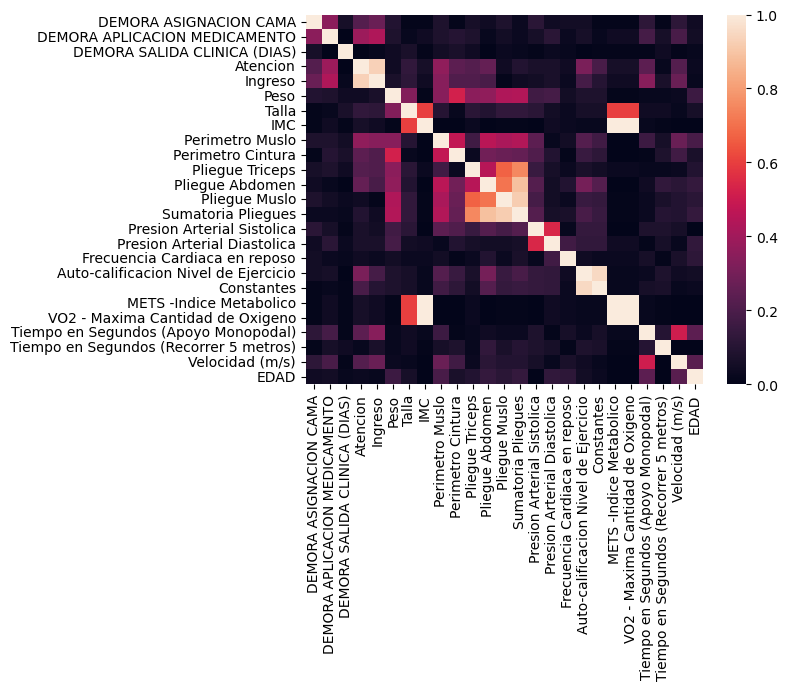

In [25]:
# Funcion para mirar la correlacion entre las variables
heatmap(df_t)

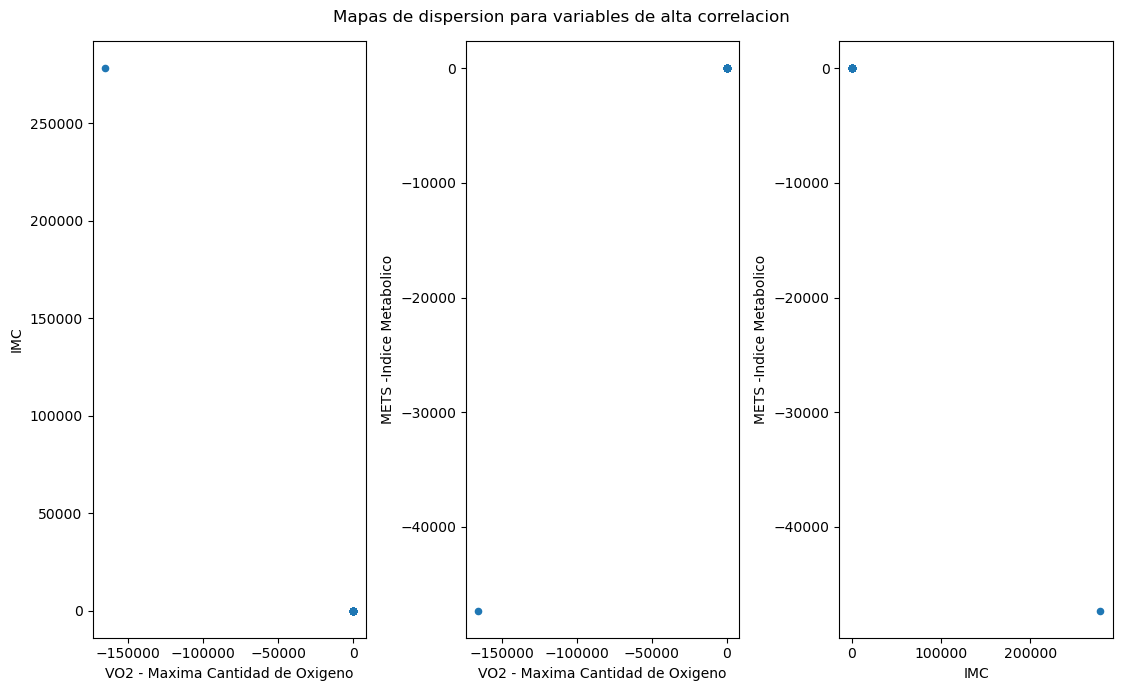

In [26]:
# Diagramas de dispersion para variables altamente relacionadas segun mapa de calor
scatterplots(["VO2 - Maxima Cantidad de Oxigeno", "IMC", "METS -Indice Metabolico"], df_t, ncols=3, nrows=1)

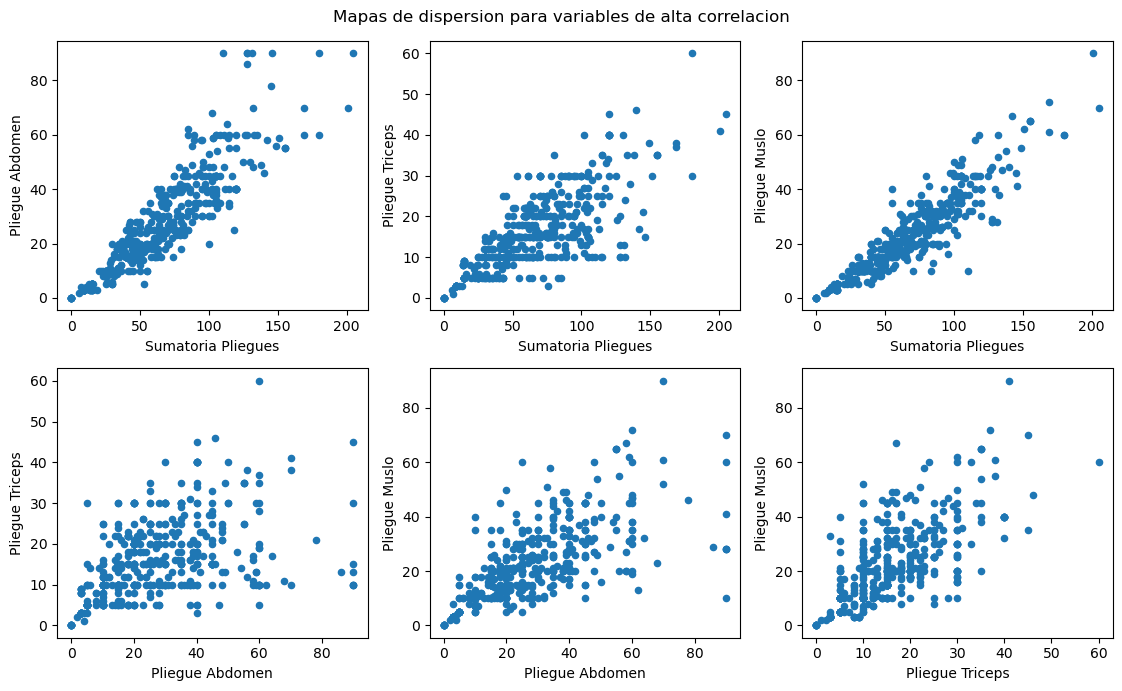

In [27]:
# Diagramas de dispersion para variables altamente relacionadas segun mapa de calor
scatterplots(["Sumatoria Pliegues", "Pliegue Abdomen", "Pliegue Triceps", "Pliegue Muslo"], df_t, ncols=3, nrows=2)

## Distribucion de categorias variables categoricas

In [30]:
# Porcentaje de presencia de las categorias en la variables categoricas
wid_1 = widgets.Dropdown(options=df_t.select_dtypes("object").columns, value="PROFESIONAL ESPECIALIDAD GRD")

def prop(col):

  df = df_t[col].value_counts(normalize=True).to_frame().style.background_gradient(axis=None)
  display(df)

output = interactive_output(prop, {"col":wid_1})

display(wid_1, output)





Dropdown(index=8, options=('SERVICIO ADMITE', 'UNIDAD ESTRATEGICA', 'TRANSFUSION SANGRE', 'ANTIBIOTICO', 'DXPR…

Output()

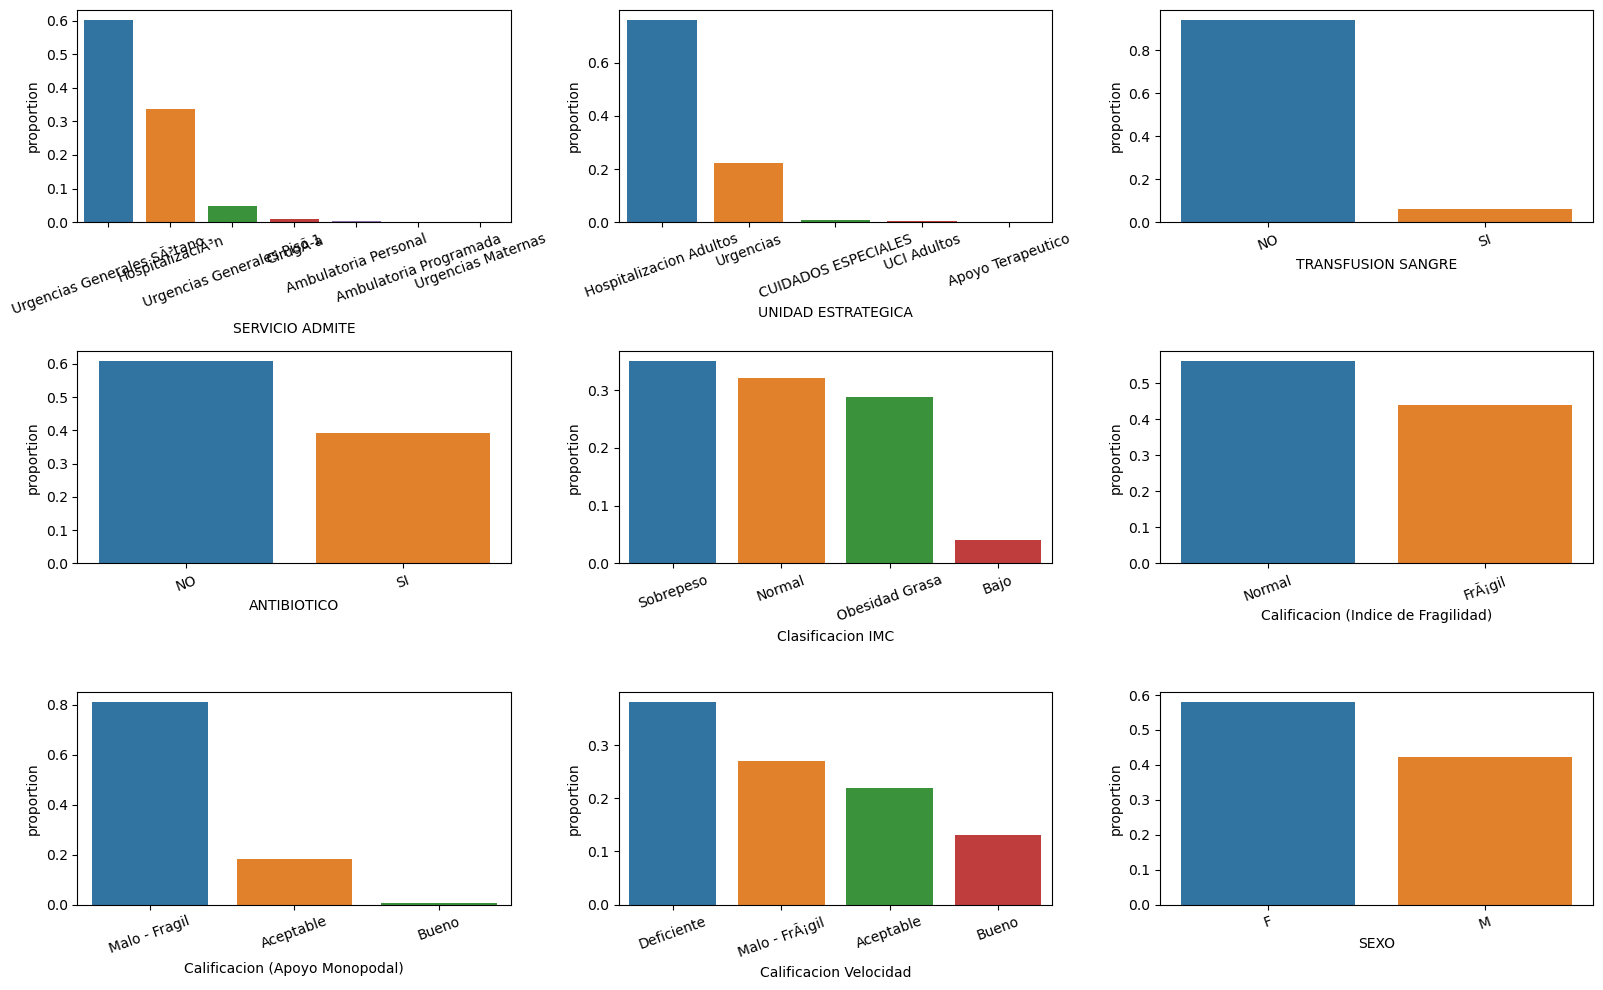

In [31]:
# Crear figura
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10*((1+np.sqrt(5))/2), 10))
i = 0
j = 0

# Crear diagrama de barras para cada variable categorica
for x in df_t.select_dtypes("object").drop(df_t.columns[df_t.columns.str.startswith("DX")], axis=1).drop("PROFESIONAL ESPECIALIDAD GRD", axis=1).columns:

    # DataFrame con los valores por categoria
    df = df_t[x].value_counts(normalize=True).to_frame()\
    # Diagrama de barras
    sns.barplot(data=df, x=df.index, y="proportion", ax=axes[i, j], hue=df.index)
    # Ajustar etiquetas de los ejes
    plt.setp(axes[i, j].xaxis.get_majorticklabels(), rotation=20)

    if j!=0 and (j+1)%3 == 0:
        j = 0
        i += 1
    else:
        j += 1

# Ajustar layout
plt.tight_layout()


## Correlacion con variable objetivo

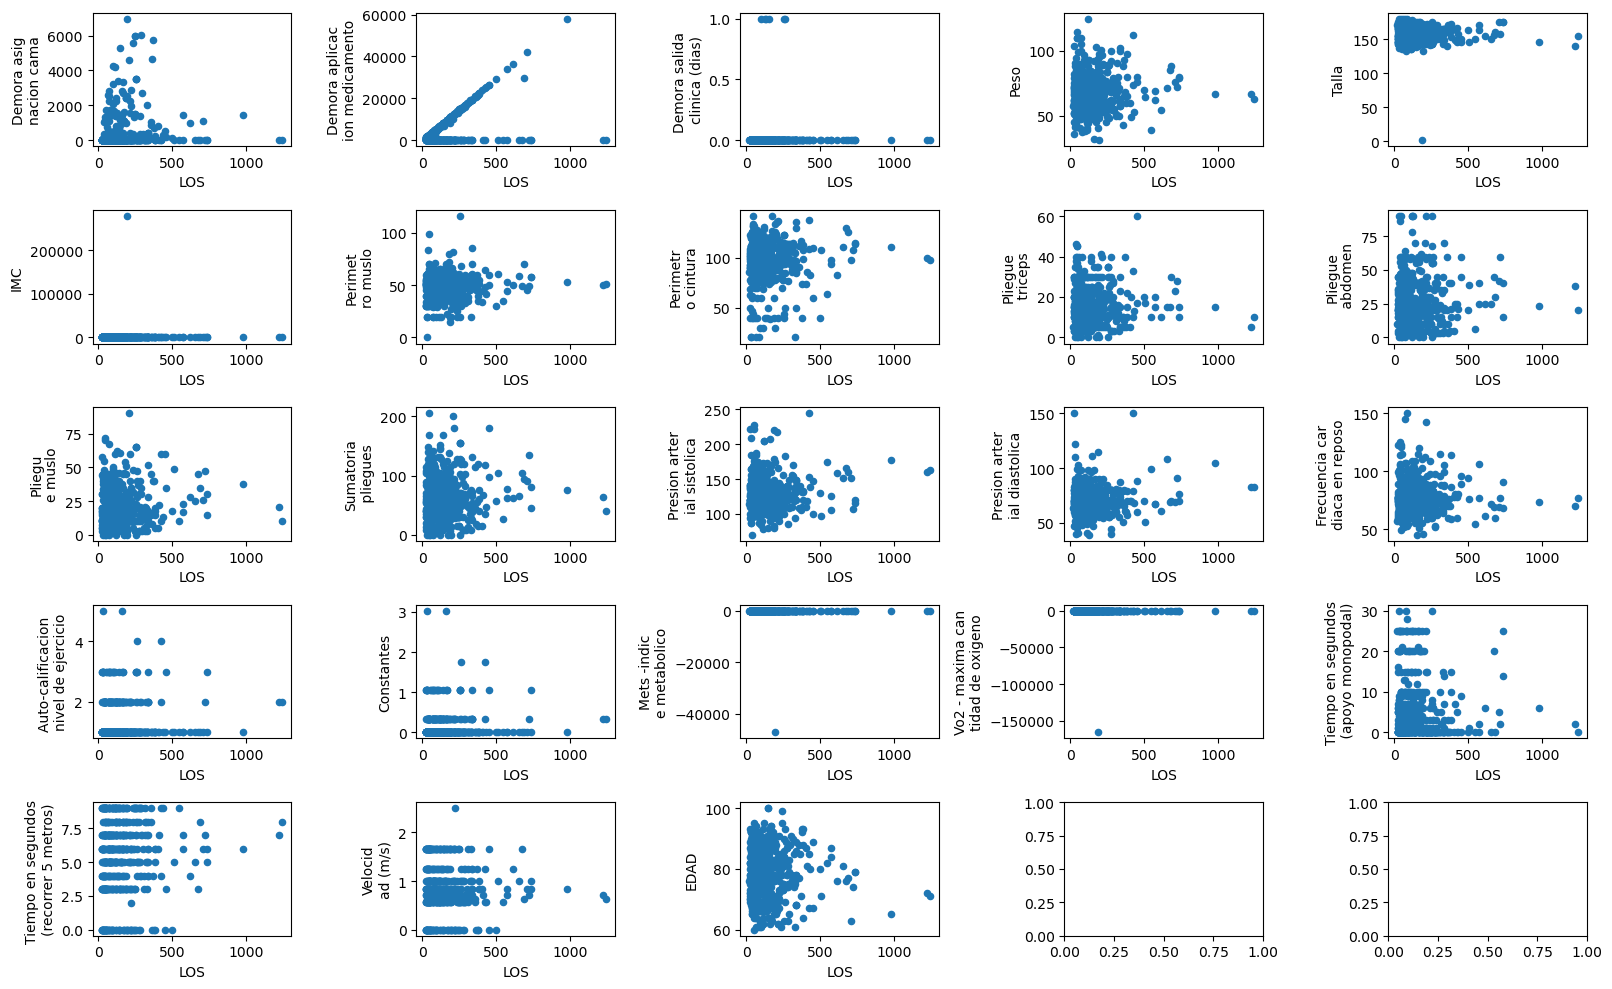

In [32]:
# Crear figura
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10*((1+np.sqrt(5))/2), 10))
i = 0
j = 0

# Crear diagrama de dispersion de  variables numericas vs variable objetivo
for y in df_t._get_numeric_data().drop(["NRODOC", "Atencion", "Ingreso"], axis=1).columns:

    # Copiar DataFrame
    df = df_t.copy()
    # Convertir variable objetivo a horas
    df["LOS"] = df["LOS"].dt.total_seconds()/3600

    # Ajustar Titulos en eje y
    if len(y) > 10:
      df[["LOS", y]].plot.scatter(x="LOS", y=y, ax=axes[i,j], ylabel=f'{y[:int(len(y)/2)]}\n{y[int(len(y)/2):]}'.capitalize(), xlabel="LOS")
    else:
      df[["LOS", y]].plot.scatter(x="LOS", y=y, ax=axes[i,j], ylabel=f'{y}', xlabel="LOS")


    if j!=0 and (j+1)%5 == 0:
        j = 0
        i += 1
    else:
        j += 1

# Ajustar Layout
plt.tight_layout()

## Distribucion variables numericas

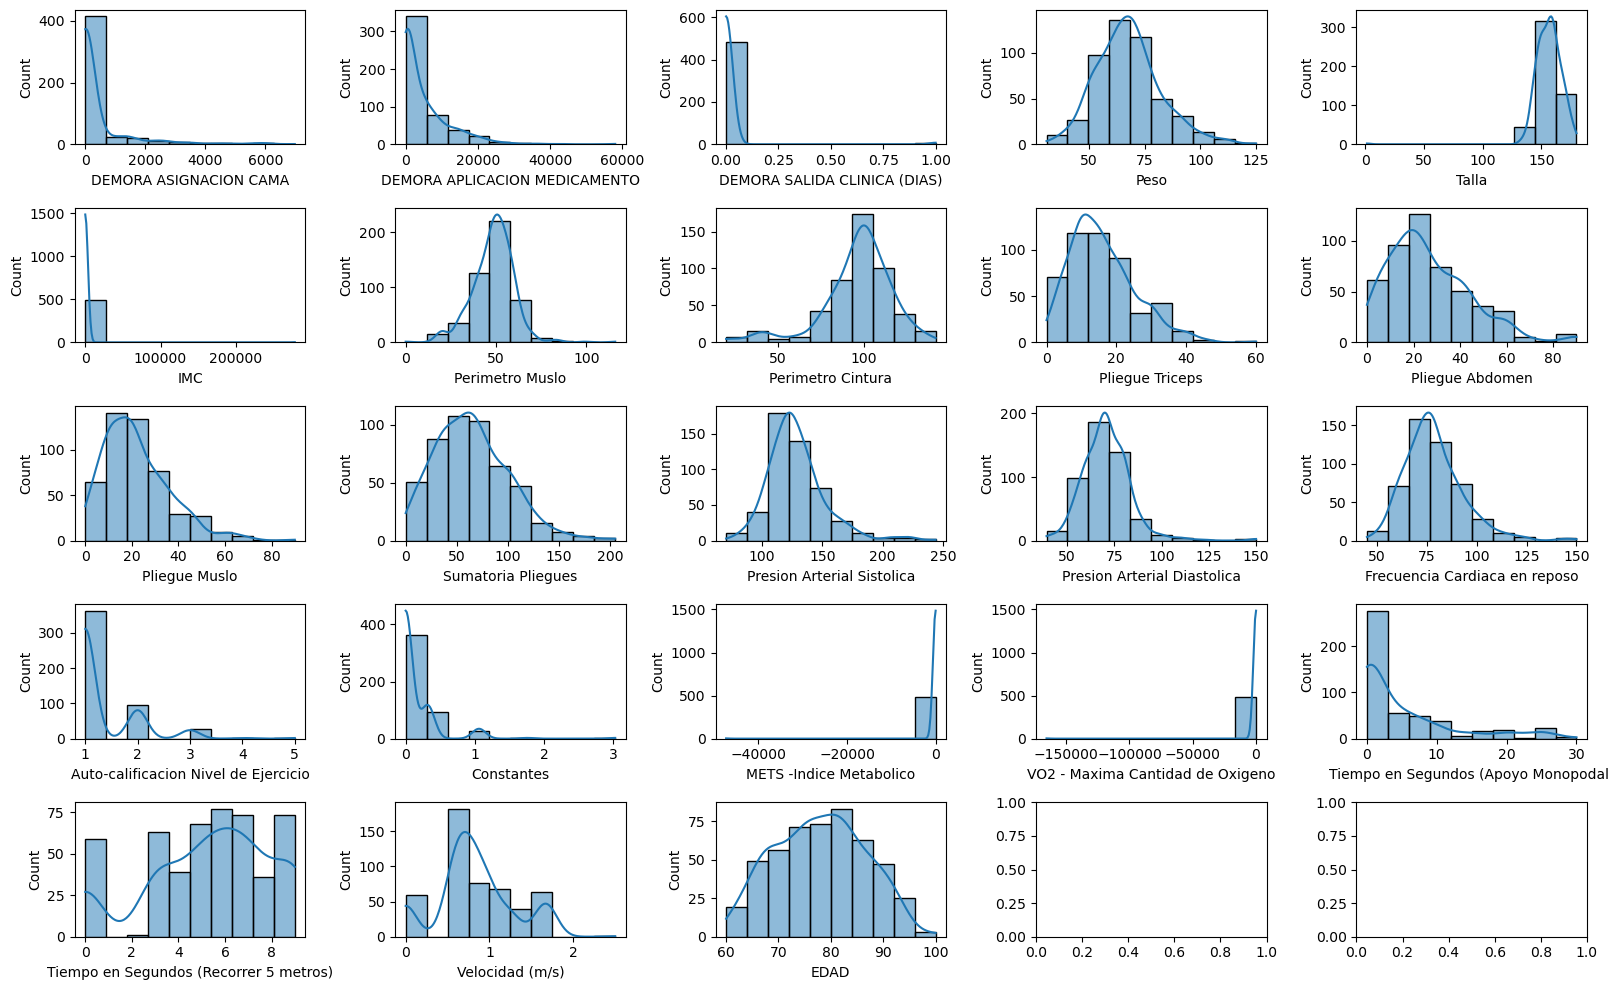

In [33]:
# Crear figura
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10*((1+np.sqrt(5))/2), 10))
i = 0
j = 0

# Crear histograma de variables numericas
for x in df_t._get_numeric_data().drop(["NRODOC", "Atencion", "Ingreso"], axis=1).columns:

    # Copiar DataFrame
    df = df_t.copy()
    # Crear histogramas
    sns.histplot(data=df, x=x, ax=axes[i, j], kde=True, bins=10)

    if j!=0 and (j+1)%5 == 0:
        j = 0
        i += 1
    else:
        j += 1
# Ajustar Layout
plt.tight_layout()

## Distribucion variables numericas (luego de ajuste normal)

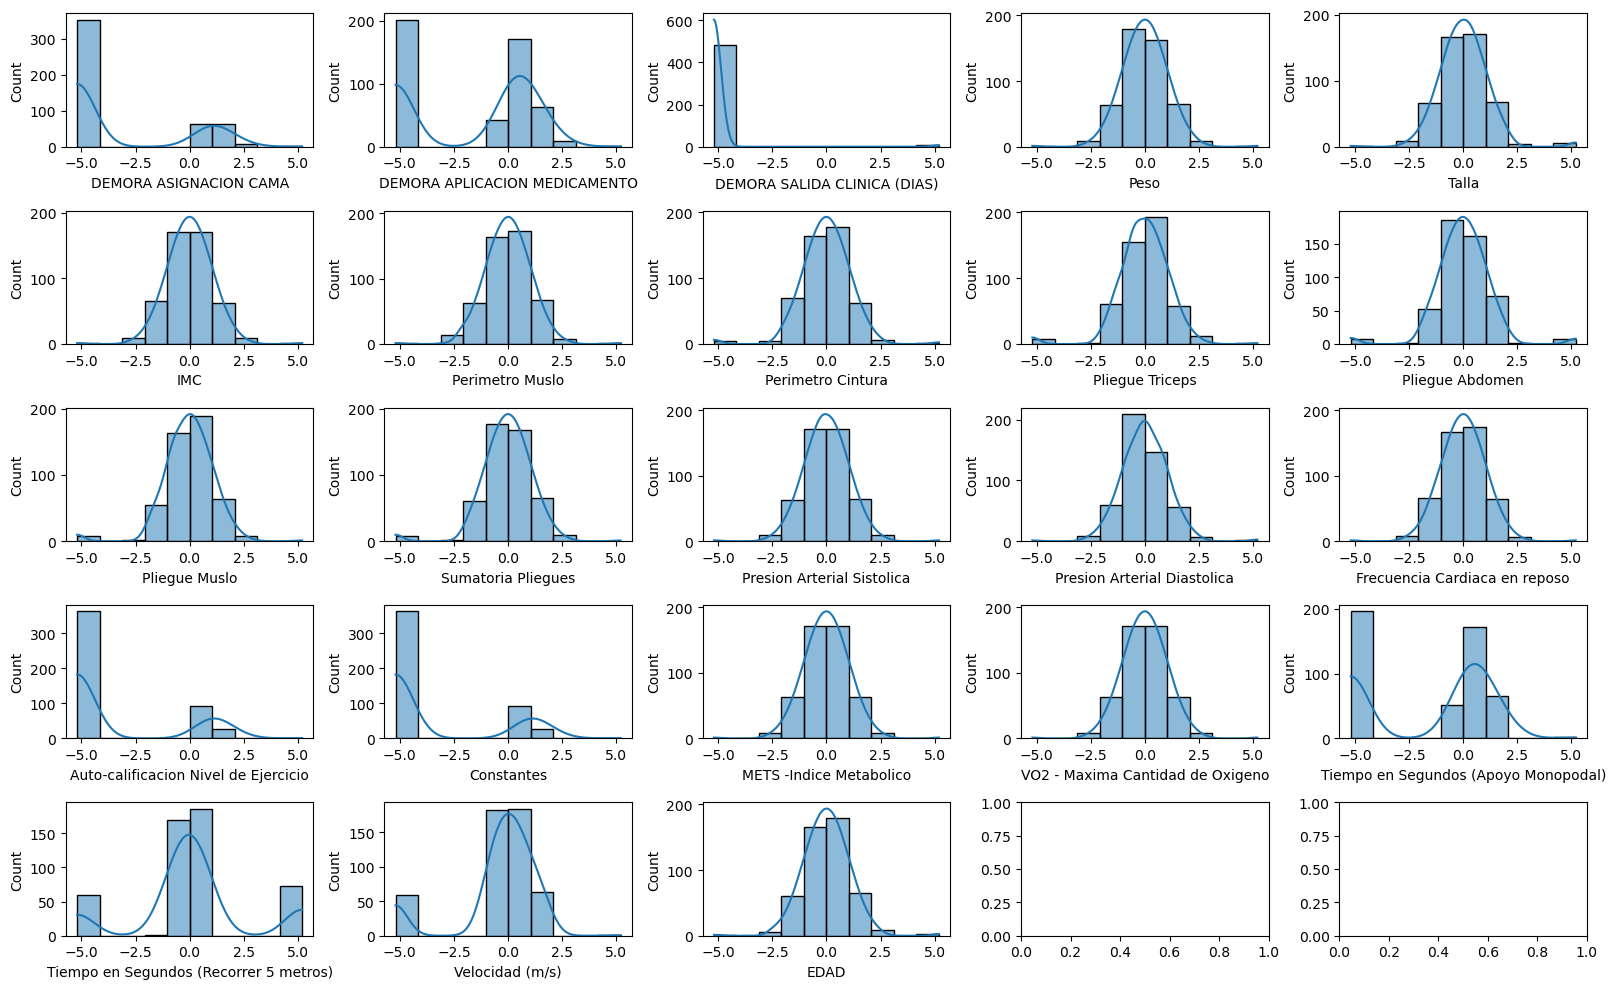

In [34]:
# Transformar varibales numericas a distribucion normal
transformer = QuantileTransformer(n_quantiles=len(df_t), output_distribution="normal")
# Variables numericas, eliminando variables con informacion no valiosa
X = df_t._get_numeric_data().drop(["NRODOC", "Atencion", "Ingreso"], axis=1)

# DataFrame con variables transformadas
X = pd.DataFrame(transformer.fit_transform(X), columns = X.columns)


# Crear figura
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10*((1+np.sqrt(5))/2), 10))
i = 0
j = 0

# Crear histograma de variables numericas
for x in df_t._get_numeric_data().drop(["NRODOC", "Atencion", "Ingreso"], axis=1).columns:


    # Crear histogramas
    sns.histplot(data=X, x=x, ax=axes[i, j], kde=True, bins=10)

    if j!=0 and (j+1)%5 == 0:
        j = 0
        i += 1
    else:
        j += 1
# Ajustar Layout
plt.tight_layout()

## Eliminacion de variables luego de EDA

In [35]:
# Eliminar variables correlacionadas y con demasiadas categorias
to_drop = ["VO2 - Maxima Cantidad de Oxigeno", "METS -Indice Metabolico", "Sumatoria Pliegues", "PROFESIONAL ESPECIALIDAD GRD", "Constantes"] + df_t.columns[df_t.columns.str.contains("(^DX)")].values.tolist()
df_t.drop(to_drop, axis=1, inplace=True)

# Seleccion de variables

In [36]:
# Funcion para la seleccion de variables
feature_sel(df_t)

In [37]:
# Nombres de archivos generados mediante la seleccion de variables
names = [os.path.splitext(i)[0] for i in os.listdir("features")]

# Diccionario con nombres y valores de nuevas variables
dic = {}
# Leer valores
for i in names:
    with open(f"features/{i}.pkl", "rb") as f:
        x = pickle.load(f)
        dic[i] = x
# Actualizar lista de variables locales c
locals().update(dic)

## Conjuntos de variables arrojados por los algoritmos de seleccion

In [38]:
# DataFrame con los conjuntos de variables seleccionadas por el algoritmo anterior
vars_rfe

,squared_error_f_regression,absolute_error_f_regression,squared_error_mutual_info,absolute_error_mutual_info
0,ANTIBIOTICO,UNIDAD ESTRATEGICA,ANTIBIOTICO,UNIDAD ESTRATEGICA
1,UNIDAD ESTRATEGICA,Peso,UNIDAD ESTRATEGICA,Talla
2,DEMORA ASIGNACION CAMA,DEMORA ASIGNACION CAMA,Talla,DEMORA ASIGNACION CAMA
3,SERVICIO ADMITE,Presion Arterial Diastolica,DEMORA ASIGNACION CAMA,DEMORA APLICACION MEDICAMENTO
4,Presion Arterial Diastolica,Presion Arterial Sistolica,DEMORA APLICACION MEDICAMENTO,Calificacion Velocidad
5,Presion Arterial Sistolica,Pliegue Muslo,SERVICIO ADMITE,Calificacion (Indice de Fragilidad)
6,Pliegue Muslo,Tiempo en Segundos (Apoyo Monopodal),Calificacion (Indice de Fragilidad),Frecuencia Cardiaca en reposo
7,Tiempo en Segundos (Apoyo Monopodal),Tiempo en Segundos (Recorrer 5 metros),Frecuencia Cardiaca en reposo,Presion Arterial Sistolica
8,Tiempo en Segundos (Recorrer 5 metros),SEXO,Presion Arterial Sistolica,Pliegue Triceps
9,SEXO,Calificacion (Apoyo Monopodal),Pliegue Triceps,Auto-calificacion Nivel de Ejercicio


## Resultado de los algoritmos de prediccion con cada conjunto de variables seleccionadas

- Las columnas `recurrente` y `all_feat` corresponden a la evalucion de los modelos con las variables mas repetidas entre los 4 algoritmos de seleccion y la evaluacion teniendo en cuenta todas las variables escogidas por nosotros luego del EDA

In [39]:
# DataFrame con los MSE del cada algoritmo usando los diferentes conjuntos de variables
eval_df

,squared_error_f_regression,absolute_error_f_regression,squared_error_mutual_info,absolute_error_mutual_info,recurrente,all_feat
rf,106.983926,114.543706,67.948310,67.998254,71.790381,71.790381
gb,109.243336,115.201697,72.495440,74.393722,73.960421,73.960421
svr,105.550532,105.960629,103.454399,103.881355,105.134044,105.134044


# Ajuste de hyperparametros

In [40]:
# Funcion para entrenar hyperparametros
hyper_tunning(df_t)

Fitting 7 folds for each of 27 candidates, totalling 189 fits


# Resultados

## Mejores Parametros de modelo seleccionado

In [41]:
# Leer variables utilizadas para entrenamiento
with open("models/best_model/features.pkl", "rb") as f:
        features = pickle.load(f)

# Leer mejor model
with open("models/best_model/best_model.pkl", "rb") as f:
        model = pickle.load(f)

# DataFrame con los hyperparametros del mejor model
pd.DataFrame(model.named_steps["randomforestregressor"].get_params().values(), index=model.named_steps["randomforestregressor"].get_params().keys(), columns=["Valor"])

,Valor
bootstrap,True
ccp_alpha,0.0
criterion,squared_error
max_depth,None
max_features,sqrt
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2


## Metricas de desempeño

In [42]:
# Variable objetivo
target = "LOS"

# DataFrame con las variables a utilizar
X = df_t[features]
# Convertir variable objetivo a hora
y = df_t[target].dt.total_seconds()/3600

# Dividir datos de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Realizar prediccion
pred = model.predict(X_test)

# Metricas a evaluar con la prediccion
metrics = [mean_squared_error, mean_absolute_error, r2_score]

# Lista de resultados
result = [i(y_test, pred) for i in metrics] + [np.sqrt(mean_squared_error(y_test, pred))]

# DataFrame con los resultados de las metricas
df_results = pd.DataFrame(result, index=["MSE", "MAE", "R2", "RMSE"], columns=["Puntaje"])

df_results

,Puntaje
MSE,33748.830837
MAE,76.454225
R2,0.112204
RMSE,183.708549
